# Sistemas Biometricos / Biometric Systems
## ECG Biometrics
## 30/09/2024


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb

# Database from Physionet
https://physionet.org/content/ecgiddb/1.0.0/

In [3]:
signals1, fields1 = wfdb.rdsamp('ecg-id-database-1.0.0/Person_01/rec_1')
signals2, fields1 = wfdb.rdsamp('ecg-id-database-1.0.0/Person_02/rec_1')
signals3, fields1 = wfdb.rdsamp('ecg-id-database-1.0.0/Person_03/rec_1')

In [4]:
from biosppy.signals import ecg
out1 = ecg.ecg(signal=signals1[:,1], sampling_rate=500., show=False)
out2 = ecg.ecg(signal=signals2[:,1], sampling_rate=500., show=False)
out3 = ecg.ecg(signal=signals3[:,1], sampling_rate=500., show=False)

In [5]:
templates = np.zeros((71,300))
templates[0:23,:] = out1['templates']
templates[23:23+24,:] = out2['templates']
templates[47:47+24,:] = out3['templates']
templates.shape

(71, 300)

In [6]:
templates = np.vstack((out1['templates'], out2['templates'], out3['templates']))
templates.shape

(71, 300)

In [7]:
labels = np.hstack( (np.ones(len(out1['templates']))*1, np.ones(len(out2['templates']))*2, np.ones(len(out3['templates']))*3))
labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3.])

In [8]:
templates.shape

(71, 300)

# Reading data from CardioWheel
https://www.cardio-id.com/automotive/

In [9]:
data1 = np.loadtxt('SB_user1.txt')
data2 = np.loadtxt('SB_user2.txt')
data3 = np.loadtxt('SB_user3.txt')

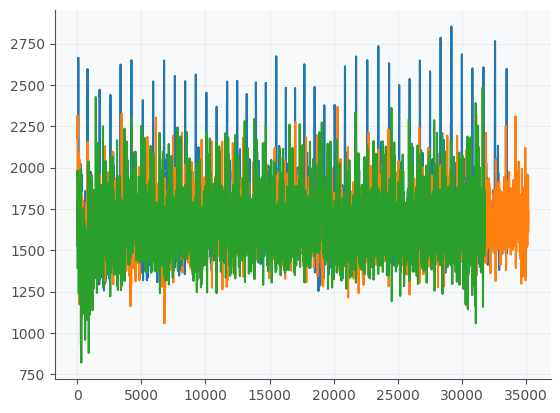

In [21]:
plt.plot(data1[:,1])
plt.plot(data2[:,1])
plt.plot(data3[:,1])

In [24]:
fs = 1000
# show 5 s of signal?
data1.shape

(33600, 3)

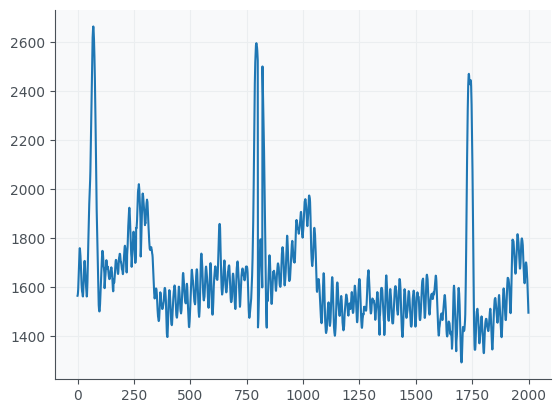

In [27]:
plt.plot(data1[0:2*fs,1])

## Notch Filtering 
Band rejection filtering

In [29]:
import scipy.signal as ss
fs = 1000.
# notch filter
notch_freq = 50.0 # Frequency to be removed from signal (Hz)
quality_factor = 20.0 # Quality factor
# Design a notch filter using signal.iirnotch
b_notch, a_notch = ss.iirnotch(notch_freq, quality_factor, fs)

# Compute magnitude response of the designed filter
freq, h = ss.freqz(b_notch, a_notch, fs=fs)

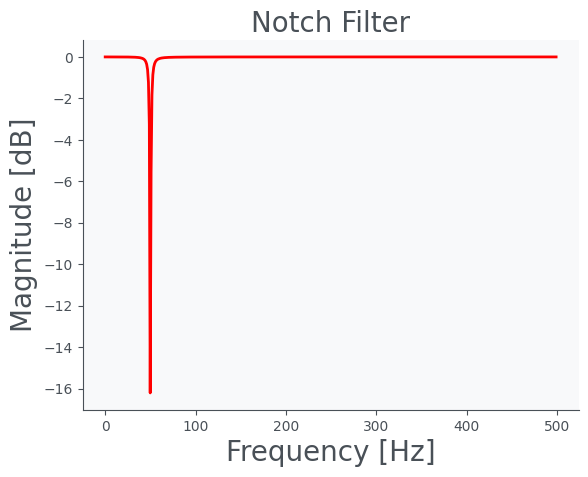

In [30]:
# Plot magnitude response of the filter
plt.plot(freq, 20 * np.log10(abs(h)),
		'r', linewidth='2')

plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Magnitude [dB]', fontsize=20)
plt.title('Notch Filter', fontsize=20)
plt.grid()


# Filtering a Signal
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#lfilter

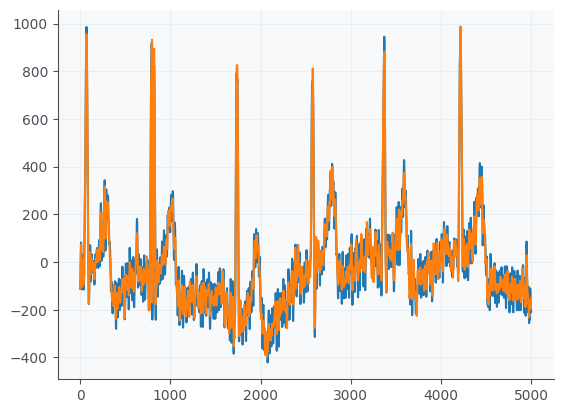

In [14]:
# Apply notch notch
data = data1[:,1]-np.mean(data1[:,1])
outputSignal = ss.lfilter(b_notch, a_notch, data)
#outputSignal = ss.filtfilt(b_notch, a_notch, data)
plt.plot(data[:5000])
plt.plot(outputSignal[:5000])

# Showing the Spectrum

Text(0, 0.5, '|X(f)|')

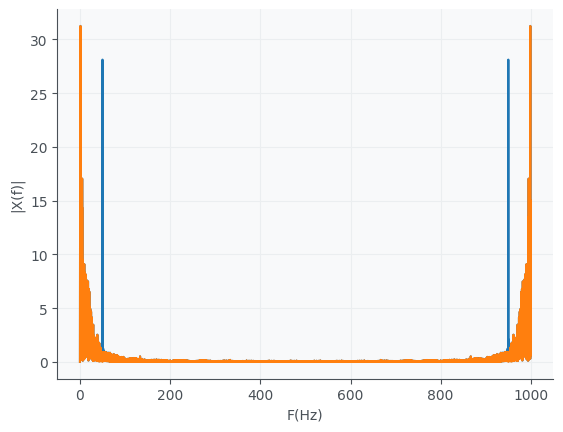

In [15]:
X = np.fft.fft(data)
f = np.arange(0,fs,fs/len(X))
plt.plot(f,np.abs(X)/len(X))
Y = np.fft.fft(outputSignal)
plt.plot(f,np.abs(Y)/len(Y))
plt.xlabel('F(Hz)')
plt.ylabel('|X(f)|')

# Baseline Removal
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html

Creating a High-pass filter

In [44]:
numtaps = 1001
fhp = 1 #Hz 
b_hp = ss.firwin(numtaps, cutoff=fhp, pass_zero=False, fs=fs)

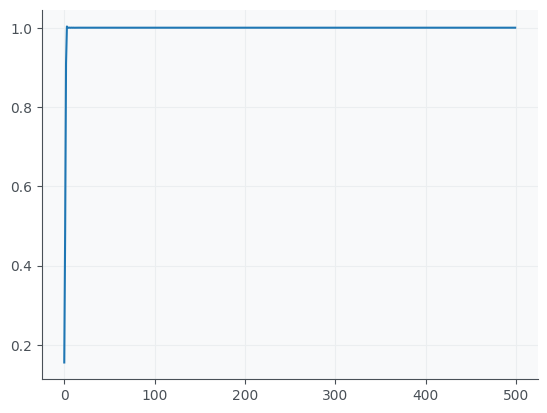

In [45]:
# Compute magnitude response of the designed filter
freq, h_hp = ss.freqz(b_hp, 1, fs=fs)
plt.plot(freq, np.abs(h_hp))

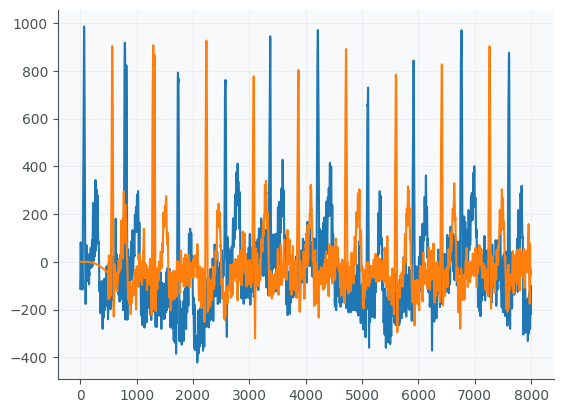

In [48]:
outputSignal2 = ss.lfilter(b_hp, 1, outputSignal)
duracao = 8
plt.plot(data[:duracao*int(fs)])
plt.plot(outputSignal2[:duracao*int(fs)])

Creating a Low-pass filter

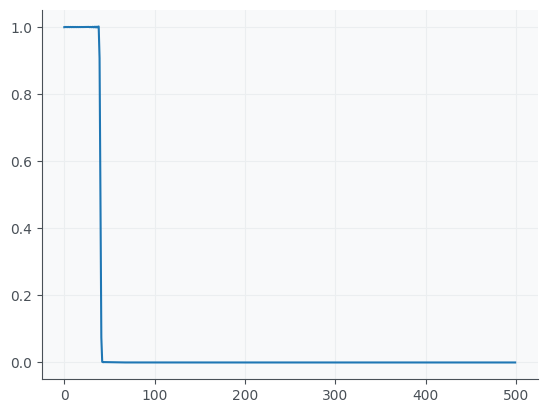

In [49]:
numtaps = 1001
flp = 40 #Hz 
b_lp = ss.firwin(numtaps, cutoff=flp, pass_zero=True, fs=fs)
# Compute magnitude response of the designed filter
freq, h_lp = ss.freqz(b_lp, 1, fs=fs)
plt.plot(freq, np.abs(h_lp))

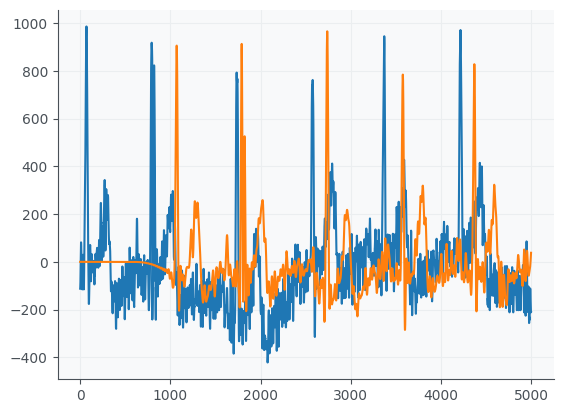

In [51]:
outputSignal3 = ss.lfilter(b_lp, 1, outputSignal2)
duracao = 5
plt.plot(data[:duracao*int(fs)])
plt.plot(outputSignal3[:duracao*int(fs)])

In [60]:
import biosppy.signals
out = biosppy.signals.ecg.hamilton_segmenter(outputSignal3, 1000)

In [63]:
out.keys()

['rpeaks']

In [64]:
out['rpeaks']

array([ 1071,  1791,  2739,  3577,  4370,  5217,  6103,  6914,  7762,
        8606,  9411, 10241, 11064, 11864, 12685, 13476, 14219, 14939,
       15705, 16524, 17274, 17990, 18718, 19519, 20272, 21085, 21887,
       22755, 23625, 24489, 25328, 26120, 26934, 27738, 28528, 29350,
       30192, 31013, 31829, 32695])

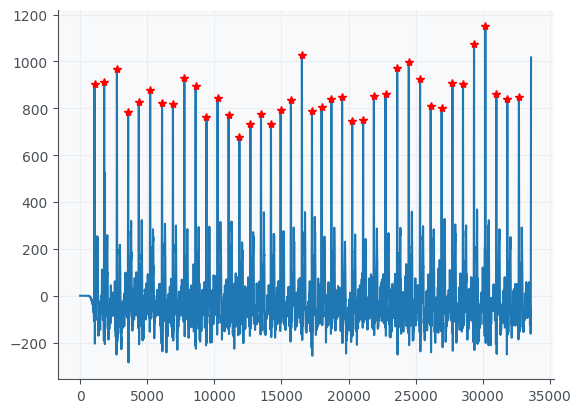

In [65]:
plt.plot(outputSignal3)
plt.plot(out['rpeaks'],outputSignal3[out['rpeaks']],'*r')

In [68]:
out['rpeaks']
newTemplates = np.zeros((len(out['rpeaks']), 600))
for i in range(len(out['rpeaks'])):
    p = out['rpeaks'][i]
    newTemplates[i,:] = outputSignal3[p-200:p+400]

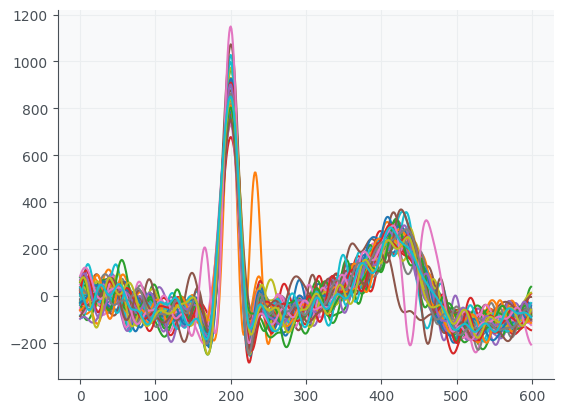

In [70]:
plt.plot(newTemplates.T)

# In Biosppy ECG method we are doing all of this

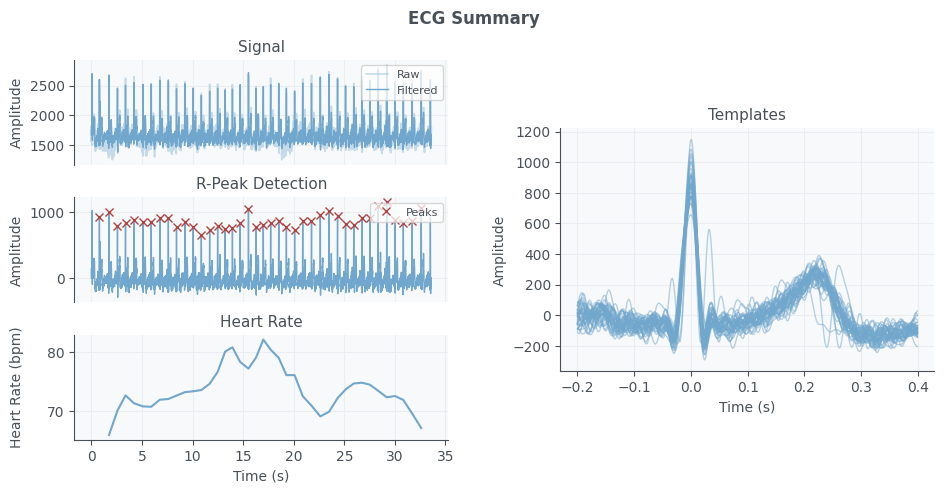

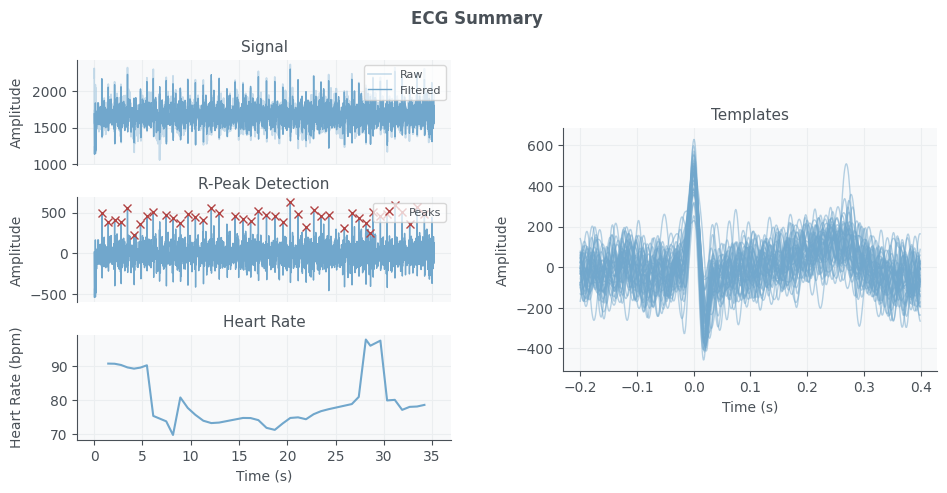

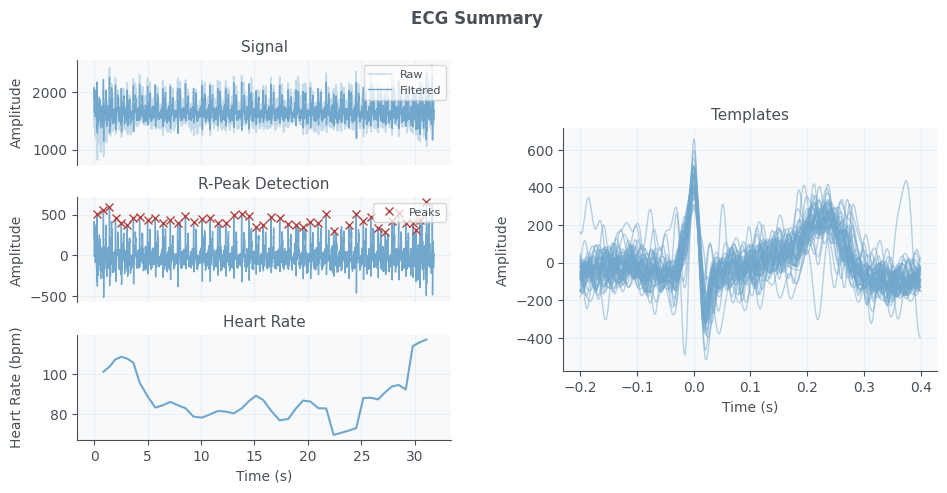

In [16]:
from biosppy.signals import ecg
out1 = ecg.ecg(signal=data1[:,1], sampling_rate=1000., show=True)
out2 = ecg.ecg(signal=data2[:,1], sampling_rate=1000., show=True)
out3 = ecg.ecg(signal=data3[:,1], sampling_rate=1000., show=True)